In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTModel

In [ ]:
# Mount Google Drive (only for Colab)
drive.mount('/content/drive')

# ========================================================================
# 1. Dataset Configuration
# ========================================================================
dataset_paths = {
    'Normal': '/content/drive/MyDrive/OS Dataset/Normal/',
    'Osteopenia': '/content/drive/MyDrive/OS Dataset/Osteopenia/',
    'Osteoporosis': '/content/drive/MyDrive/OS Dataset/Osteoporosis/'
}

# ========================================================================
# 2. Image Loading & Preprocessing
# ========================================================================
def load_images_and_labels(folder_path, label):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder_path, filename)
            try:
                # Load image and verify successful read
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue

                # Critical Fix 1: Resize to ViT's required 224x224
                img = cv2.resize(img, (224, 224))

                # Critical Fix 2: Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Critical Fix 3: Convert to channels-first format
                img = np.transpose(img, (2, 0, 1))  # (3, 224, 224)

                # Critical Fix 4: Normalize to [-1, 1] range
                img = (img.astype(np.float32) / 127.5) - 1.0

                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(images), np.array(labels)

# ========================================================================
# 3. Load and Prepare Data
# ========================================================================
# Load datasets
normal_images, normal_labels = load_images_and_labels(dataset_paths['Normal'], 0)
osteopenia_images, osteopenia_labels = load_images_and_labels(dataset_paths['Osteopenia'], label=1)
osteoporosis_images, osteoporosis_labels = load_images_and_labels(dataset_paths['Osteoporosis'], label=2)

# Combine and shuffle data
x_data = np.concatenate([normal_images, osteopenia_images, osteoporosis_images], axis=0)
y_data = np.concatenate([normal_labels, osteopenia_labels, osteoporosis_labels], axis=0)

# Random shuffle with fixed seed for reproducibility
np.random.seed(42)
shuffle_idx = np.random.permutation(len(x_data))
x_data = x_data[shuffle_idx]
y_data = y_data[shuffle_idx]

# ========================================================================
# 4. Train/Validation/Test Split
# ========================================================================
# Stratified split to maintain class balance
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data,
    test_size=0.2,
    stratify=y_data,
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val,
    test_size=0.1,  # 10% of training for validation
    stratify=y_train_val,
    random_state=42
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(f'Number of Normal Images: {len(normal_images)}')
print(f'Number of Oesteopenia Images: {len(osteopenia_images)}')
print(f'Number of Oestroporosis Images: {len(osteoporosis_images)}')

Number of Normal Images: 780
Number of Oesteopenia Images: 374
Number of Oestroporosis Images: 793


In [ ]:
# Step 2: Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 3: DWT Implementation
def dwt_haar(img):
    """Performs Haar wavelet transform on a batch of images."""
    # img shape: (batch, channels, height, width)
    batch, channels, h, w = img.shape

    # Split rows into even and odd indices
    even_rows = img[:, :, 0::2, :]
    odd_rows = img[:, :, 1::2, :]

    # Compute row-wise averages and differences
    avg_rows = (even_rows + odd_rows) / 2
    diff_rows = (even_rows - odd_rows) / 2

    # Split columns for avg_rows (LL and HL)
    even_cols_avg = avg_rows[:, :, :, 0::2]
    odd_cols_avg = avg_rows[:, :, :, 1::2]
    LL = (even_cols_avg + odd_cols_avg) / 2
    HL = (even_cols_avg - odd_cols_avg) / 2

    # Split columns for diff_rows (LH and HH)
    even_cols_diff = diff_rows[:, :, :, 0::2]
    odd_cols_diff = diff_rows[:, :, :, 1::2]
    LH = (even_cols_diff + odd_cols_diff) / 2
    HH = (even_cols_diff - odd_cols_diff) / 2

    return torch.cat([LL, HL, LH, HH], dim=1)

# Step 4: Dataset Class (unchanged)
class NumpyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.x_data[idx]).float()
        label = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return image, label

Using device: cuda


In [ ]:
# Step 5: Modified ViT Model with DWT Processing (3-class version)
class ViTMultiClassClassifier(nn.Module):
    def __init__(self, pretrained_model='google/vit-base-patch16-224-in21k'):
        super().__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model)
        self.classifier = nn.Linear(self.vit.config.hidden_size * 4, 3)  # 3 output classes
        # Removed sigmoid - CrossEntropyLoss includes softmax

        # Freeze ViT parameters
        for param in self.vit.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Apply Haar DWT
        x_dwt = dwt_haar(x)
        batch_size = x_dwt.size(0)

        # Reshape and process each subband
        x_dwt = x_dwt.view(batch_size, 4, 3, 112, 112)
        vit_outputs = []

        for i in range(4):
            subband = x_dwt[:, i, :, :, :]
            subband_up = F.interpolate(subband, size=(224, 224),
                                     mode='bilinear', align_corners=False)
            outputs = self.vit(subband_up)
            vit_outputs.append(outputs.last_hidden_state[:, 0, :])

        # Concatenate and classify
        combined = torch.cat(vit_outputs, dim=1)
        return self.classifier(combined)  # Return raw logits

# Step 6: Create Verified Datasets and DataLoaders
class NumpyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return (
            torch.tensor(self.x[index], dtype=torch.float32),
            torch.tensor(self.y[index], dtype=torch.long)  # Crucial for CrossEntropyLoss
        )

# Verify data shapes and labels first!
print("Data verification:")
print(f"Train labels: {np.unique(y_train)}")
print(f"Val labels: {np.unique(y_val)}")
print(f"Test labels: {np.unique(y_test)}")

batch_size = 32
train_dataset = NumpyDataset(x_train, y_train)
val_dataset = NumpyDataset(x_val, y_val)
test_dataset = NumpyDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Step 7: Initialize Model
model = ViTMultiClassClassifier().to(device)

# Step 8: Loss and Optimizer (3-class compatible)
criterion = nn.CrossEntropyLoss()  # Changed from BCELoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Data verification:
Train labels: [0 1 2]
Val labels: [0 1 2]
Test labels: [0 1 2]


In [ ]:
import time
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Modified training loop for 3-class classification
num_epochs = 500
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
early_stop = False
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True
)

print(f"\n{'='*50}")
print(f"Starting training with early stopping (patience={patience})")
print(f"and learning rate scheduling (ReduceLROnPlateau)")
print(f"{'='*50}\n")

for epoch in range(num_epochs):
    if early_stop:
        print(f"[!] Early stopping triggered at epoch {epoch+1}")
        break

    epoch_start = time.time()

    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Train]") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # Shape: [batch_size, 3]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_batches += 1

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'AvgLoss': f"{(train_loss/(train_batches*images.size(0))):.4f}"
            })

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Val]  ") as pbar:
        with torch.no_grad():
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)  # Get class indices
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                pbar.set_postfix({
                    'Loss': f"{loss.item():.4f}",
                    'Acc': f"{(correct/total):.4f}"
                })

    # Calculate metrics
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    current_lr = optimizer.param_groups[0]['lr']

    # Update learning rate
    scheduler.step(epoch_val_loss)

    # Store history
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Early stopping logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        improvement_msg = f"(▼ {best_val_loss - epoch_val_loss:.4f})"
    else:
        epochs_no_improve += 1
        improvement_msg = f"(▲ {epoch_val_loss - best_val_loss:.4f}) [Patience left: {patience - epochs_no_improve}]"
        if epochs_no_improve >= patience:
            early_stop = True

    # Calculate epoch duration
    epoch_time = time.time() - epoch_start
    time_remaining = (epoch_time * (num_epochs - epoch - 1)) / 3600 if not early_stop else 0

    # Detailed epoch report
    print(f"\nEpoch {epoch+1:3d}/{num_epochs} | Duration: {epoch_time:.1f}s | Remaining: ~{time_remaining:.1f}h")
    print(f"Train Loss: {epoch_train_loss:.4f}")
    print(f"Val Loss:   {epoch_val_loss:.4f} {improvement_msg}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"-"*60)

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("\nLoaded best model weights for final testing")

# Final evaluation
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

with tqdm(test_loader, unit="batch", desc="Final Testing") as pbar:
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Acc': f"{(test_correct/test_total):.4f}"
            })

print(f"\n{'='*50}")
print(f"Final Test Results:")
print(f"Loss: {test_loss/len(test_dataset):.4f}")
print(f"Accuracy: {test_correct/test_total:.4f}")
print(f"{'='*50}")


Starting training with early stopping (patience=20)
and learning rate scheduling (ReduceLROnPlateau)



Epoch   1/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.6616, Acc=0.6026]



Epoch   1/500 | Duration: 76.4s | Remaining: ~10.6h
Train Loss: 0.7984
Val Loss:   0.7688 (▼ 0.0000)
Val Acc:    0.6026
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   2/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.5873, Acc=0.6923]



Epoch   2/500 | Duration: 74.8s | Remaining: ~10.4h
Train Loss: 0.6346
Val Loss:   0.7355 (▼ 0.0000)
Val Acc:    0.6923
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   3/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.50s/batch, Loss=0.5642, Acc=0.6474]



Epoch   3/500 | Duration: 74.5s | Remaining: ~10.3h
Train Loss: 0.5917
Val Loss:   0.7113 (▼ 0.0000)
Val Acc:    0.6474
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   4/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.50s/batch, Loss=0.5180, Acc=0.6731]



Epoch   4/500 | Duration: 74.3s | Remaining: ~10.2h
Train Loss: 0.5568
Val Loss:   0.7072 (▼ 0.0000)
Val Acc:    0.6731
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   5/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.5018, Acc=0.7115]



Epoch   5/500 | Duration: 74.2s | Remaining: ~10.2h
Train Loss: 0.5236
Val Loss:   0.6926 (▼ 0.0000)
Val Acc:    0.7115
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   6/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.4910, Acc=0.7051]



Epoch   6/500 | Duration: 74.2s | Remaining: ~10.2h
Train Loss: 0.5092
Val Loss:   0.6895 (▼ 0.0000)
Val Acc:    0.7051
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   7/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.4829, Acc=0.6987]



Epoch   7/500 | Duration: 74.7s | Remaining: ~10.2h
Train Loss: 0.4923
Val Loss:   0.6867 (▼ 0.0000)
Val Acc:    0.6987
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   8/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.4965, Acc=0.6667]



Epoch   8/500 | Duration: 74.4s | Remaining: ~10.2h
Train Loss: 0.4747
Val Loss:   0.6766 (▼ 0.0000)
Val Acc:    0.6667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   9/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.56s/batch, Loss=0.4609, Acc=0.7115]



Epoch   9/500 | Duration: 74.6s | Remaining: ~10.2h
Train Loss: 0.4637
Val Loss:   0.6532 (▼ 0.0000)
Val Acc:    0.7115
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  10/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.4749, Acc=0.6795]



Epoch  10/500 | Duration: 73.5s | Remaining: ~10.0h
Train Loss: 0.4467
Val Loss:   0.6657 (▲ 0.0125) [Patience left: 19]
Val Acc:    0.6795
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  11/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.51s/batch, Loss=0.4491, Acc=0.7115]



Epoch  11/500 | Duration: 73.1s | Remaining: ~9.9h
Train Loss: 0.4394
Val Loss:   0.6631 (▲ 0.0099) [Patience left: 18]
Val Acc:    0.7115
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  12/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.4591, Acc=0.7308]



Epoch  12/500 | Duration: 76.3s | Remaining: ~10.3h
Train Loss: 0.4328
Val Loss:   0.6507 (▼ 0.0000)
Val Acc:    0.7308
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  13/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.51s/batch, Loss=0.4350, Acc=0.7179]



Epoch  13/500 | Duration: 73.3s | Remaining: ~9.9h
Train Loss: 0.4200
Val Loss:   0.6564 (▲ 0.0056) [Patience left: 19]
Val Acc:    0.7179
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  14/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.4253, Acc=0.7244]



Epoch  14/500 | Duration: 74.6s | Remaining: ~10.1h
Train Loss: 0.4088
Val Loss:   0.6484 (▼ 0.0000)
Val Acc:    0.7244
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  15/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.4248, Acc=0.7051]



Epoch  15/500 | Duration: 73.5s | Remaining: ~9.9h
Train Loss: 0.4087
Val Loss:   0.6764 (▲ 0.0280) [Patience left: 19]
Val Acc:    0.7051
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  16/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.4119, Acc=0.7244]



Epoch  16/500 | Duration: 73.5s | Remaining: ~9.9h
Train Loss: 0.3982
Val Loss:   0.6525 (▲ 0.0041) [Patience left: 18]
Val Acc:    0.7244
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  17/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.4230, Acc=0.7115]



Epoch  17/500 | Duration: 74.6s | Remaining: ~10.0h
Train Loss: 0.3863
Val Loss:   0.6429 (▼ 0.0000)
Val Acc:    0.7115
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  18/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.4088, Acc=0.7372]



Epoch  18/500 | Duration: 74.6s | Remaining: ~10.0h
Train Loss: 0.3856
Val Loss:   0.6288 (▼ 0.0000)
Val Acc:    0.7372
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  19/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.4137, Acc=0.7244]



Epoch  19/500 | Duration: 73.5s | Remaining: ~9.8h
Train Loss: 0.3751
Val Loss:   0.6389 (▲ 0.0102) [Patience left: 19]
Val Acc:    0.7244
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  20/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.3992, Acc=0.7436]



Epoch  20/500 | Duration: 73.1s | Remaining: ~9.7h
Train Loss: 0.3747
Val Loss:   0.6344 (▲ 0.0057) [Patience left: 18]
Val Acc:    0.7436
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  21/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.4058, Acc=0.7564]



Epoch  21/500 | Duration: 77.7s | Remaining: ~10.3h
Train Loss: 0.3668
Val Loss:   0.6246 (▼ 0.0000)
Val Acc:    0.7564
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  22/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.51s/batch, Loss=0.3911, Acc=0.7628]



Epoch  22/500 | Duration: 73.6s | Remaining: ~9.8h
Train Loss: 0.3611
Val Loss:   0.6369 (▲ 0.0123) [Patience left: 19]
Val Acc:    0.7628
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  23/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.4130, Acc=0.7500]



Epoch  23/500 | Duration: 73.5s | Remaining: ~9.7h
Train Loss: 0.3544
Val Loss:   0.6307 (▲ 0.0061) [Patience left: 18]
Val Acc:    0.7500
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  24/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.3926, Acc=0.7564]



Epoch  24/500 | Duration: 73.1s | Remaining: ~9.7h
Train Loss: 0.3461
Val Loss:   0.6406 (▲ 0.0160) [Patience left: 17]
Val Acc:    0.7564
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  25/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.4020, Acc=0.7628]



Epoch  25/500 | Duration: 73.4s | Remaining: ~9.7h
Train Loss: 0.3462
Val Loss:   0.6334 (▲ 0.0089) [Patience left: 16]
Val Acc:    0.7628
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  26/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.3914, Acc=0.7244]



Epoch  26/500 | Duration: 73.2s | Remaining: ~9.6h
Train Loss: 0.3385
Val Loss:   0.6542 (▲ 0.0296) [Patience left: 15]
Val Acc:    0.7244
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  27/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.3838, Acc=0.7628]



Epoch  27/500 | Duration: 73.5s | Remaining: ~9.7h
Train Loss: 0.3337
Val Loss:   0.6271 (▲ 0.0026) [Patience left: 14]
Val Acc:    0.7628
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  28/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.3842, Acc=0.7628]



Epoch  28/500 | Duration: 73.6s | Remaining: ~9.7h
Train Loss: 0.3236
Val Loss:   0.6284 (▲ 0.0038) [Patience left: 13]
Val Acc:    0.7628
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  29/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.3844, Acc=0.7564]



Epoch  29/500 | Duration: 73.7s | Remaining: ~9.6h
Train Loss: 0.3220
Val Loss:   0.6310 (▲ 0.0064) [Patience left: 12]
Val Acc:    0.7564
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  30/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.3824, Acc=0.7628]



Epoch  30/500 | Duration: 73.5s | Remaining: ~9.6h
Train Loss: 0.3213
Val Loss:   0.6266 (▲ 0.0021) [Patience left: 11]
Val Acc:    0.7628
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  31/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.3823, Acc=0.7564]



Epoch  31/500 | Duration: 73.6s | Remaining: ~9.6h
Train Loss: 0.3212
Val Loss:   0.6299 (▲ 0.0053) [Patience left: 10]
Val Acc:    0.7564
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  32/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.3826, Acc=0.7628]



Epoch  32/500 | Duration: 73.4s | Remaining: ~9.5h
Train Loss: 0.3206
Val Loss:   0.6272 (▲ 0.0026) [Patience left: 9]
Val Acc:    0.7628
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  33/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.3850, Acc=0.7628]



Epoch  33/500 | Duration: 73.5s | Remaining: ~9.5h
Train Loss: 0.3203
Val Loss:   0.6258 (▲ 0.0012) [Patience left: 8]
Val Acc:    0.7628
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  34/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.54s/batch, Loss=0.3846, Acc=0.7628]



Epoch  34/500 | Duration: 73.6s | Remaining: ~9.5h
Train Loss: 0.3188
Val Loss:   0.6263 (▲ 0.0017) [Patience left: 7]
Val Acc:    0.7628
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  35/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.3842, Acc=0.7628]



Epoch  35/500 | Duration: 73.6s | Remaining: ~9.5h
Train Loss: 0.3187
Val Loss:   0.6264 (▲ 0.0018) [Patience left: 6]
Val Acc:    0.7628
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  36/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.3837, Acc=0.7628]



Epoch  36/500 | Duration: 73.4s | Remaining: ~9.5h
Train Loss: 0.3186
Val Loss:   0.6266 (▲ 0.0020) [Patience left: 5]
Val Acc:    0.7628
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  37/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.3837, Acc=0.7628]



Epoch  37/500 | Duration: 73.3s | Remaining: ~9.4h
Train Loss: 0.3186
Val Loss:   0.6265 (▲ 0.0019) [Patience left: 4]
Val Acc:    0.7628
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  38/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.3833, Acc=0.7628]



Epoch  38/500 | Duration: 73.0s | Remaining: ~9.4h
Train Loss: 0.3186
Val Loss:   0.6262 (▲ 0.0016) [Patience left: 3]
Val Acc:    0.7628
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  39/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.3833, Acc=0.7628]



Epoch  39/500 | Duration: 73.4s | Remaining: ~9.4h
Train Loss: 0.3185
Val Loss:   0.6264 (▲ 0.0018) [Patience left: 2]
Val Acc:    0.7628
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  40/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.53s/batch, Loss=0.3833, Acc=0.7628]



Epoch  40/500 | Duration: 73.5s | Remaining: ~9.4h
Train Loss: 0.3183
Val Loss:   0.6264 (▲ 0.0019) [Patience left: 1]
Val Acc:    0.7628
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  41/500 [Val]  : 100%|██████████| 5/5 [00:07<00:00,  1.52s/batch, Loss=0.3833, Acc=0.7628]
<ipython-input-11-ea088a8e051e>:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat


Epoch  41/500 | Duration: 73.5s | Remaining: ~0.0h
Train Loss: 0.3183
Val Loss:   0.6264 (▲ 0.0018) [Patience left: 0]
Val Acc:    0.7628
Learning Rate: 1.00e-06
------------------------------------------------------------
[!] Early stopping triggered at epoch 42

Loaded best model weights for final testing


Final Testing: 100%|██████████| 13/13 [00:18<00:00,  1.43s/batch, Loss=0.8506, Acc=0.8103]


Final Test Results:
Loss: 0.5203
Accuracy: 0.8103


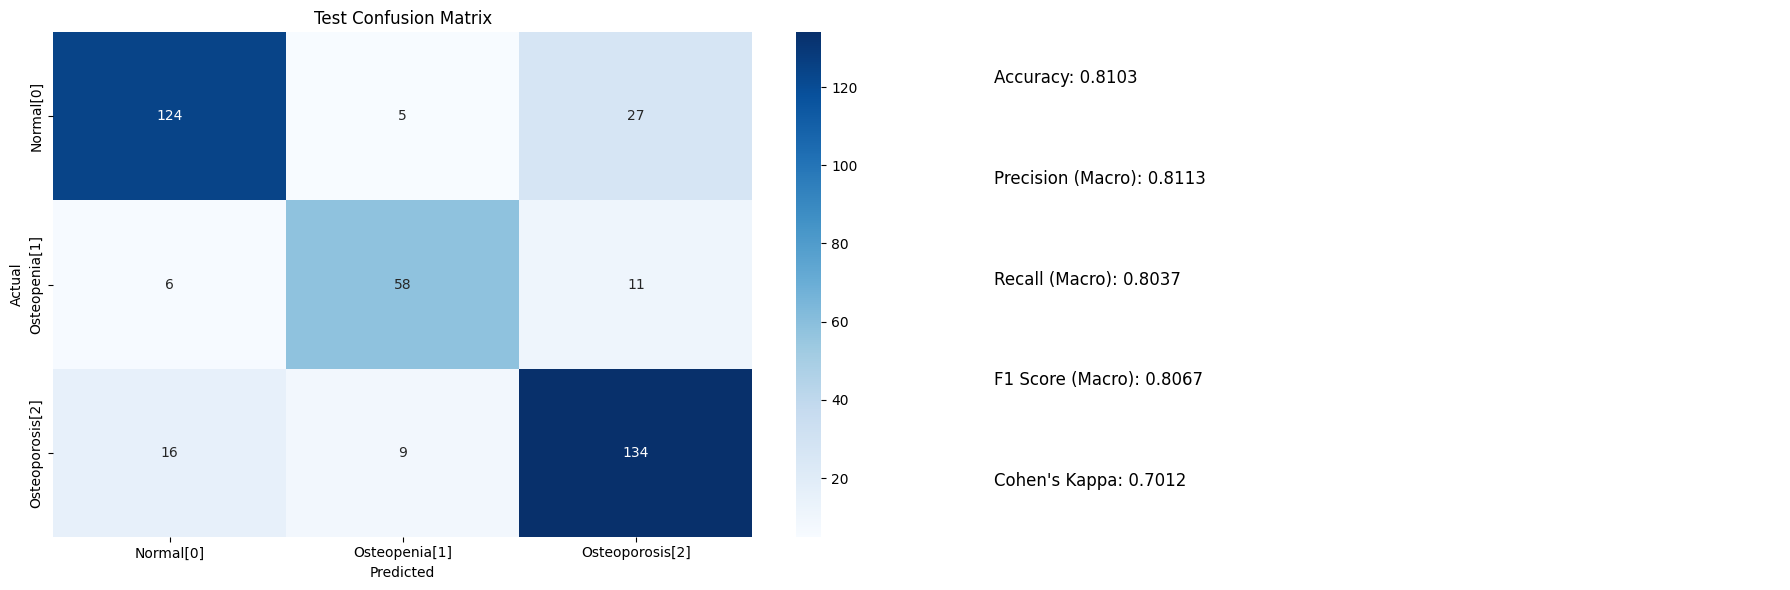

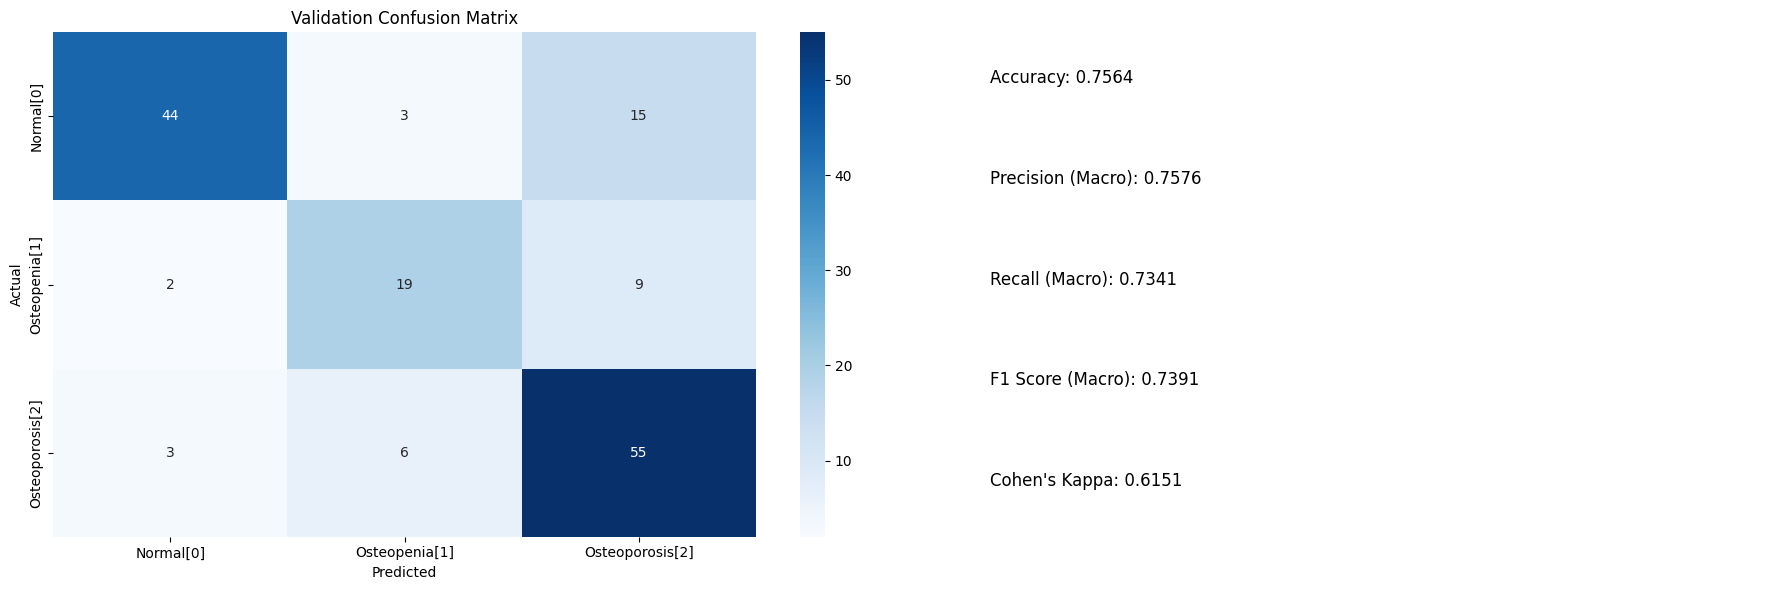

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# For accuracy graph (assuming you have training history)
train_accuracies = []  # Populate these during training
val_accuracies = []    # Populate these during validation

def plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa):
    plt.figure(figsize=(18, 6))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal[0]', 'Osteopenia[1]', 'Osteoporosis[2]'],
                yticklabels=['Normal[0]', 'Osteopenia[1]', 'Osteoporosis[2]'])
    plt.title(f'{phase_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Metrics Text
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, f'Accuracy: {accuracy:.4f}', fontsize=12)
    plt.text(0.1, 0.7, f'Precision (Macro): {precision:.4f}', fontsize=12)
    plt.text(0.1, 0.5, f'Recall (Macro): {recall:.4f}', fontsize=12)
    plt.text(0.1, 0.3, f'F1 Score (Macro): {f1:.4f}', fontsize=12)
    plt.text(0.1, 0.1, f"Cohen's Kappa: {kappa:.4f}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_model(loader, phase_name):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get class predictions

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa)

    return accuracy

# Evaluate all sets
test_accuracy = evaluate_model(test_loader, 'Test')
val_accuracy = evaluate_model(val_loader, 'Validation')